In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import random
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read the historical match data
df=pd.read_csv('../data/results.csv')
df=df.sort_index()
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [340]:
# Extract the match data that we want
fix = df[['date', 'home_team', 'away_team', 'home_score', 'away_score','tournament']]
fix.head()

,date,home_team,away_team,home_score,away_score,tournament
0,1872-11-30,Scotland,England,0.0,0.0,Friendly
1,1873-03-08,England,Scotland,4.0,2.0,Friendly
2,1874-03-07,Scotland,England,2.0,1.0,Friendly
3,1875-03-06,England,Scotland,2.0,2.0,Friendly
4,1876-03-04,Scotland,England,3.0,0.0,Friendly


In [384]:
len(fix['tournament'].unique())

139

In [414]:
# A simplified version of the FIFA world ranking model:
# https://digitalhub.fifa.com/m/f99da4f73212220/original/edbm045h0udbwkqew35a-pdf.pdf

# Predicts the expected result: P(A) winning
# Based on the elo chess ranking system
def expected(a_rating, b_rating):
    return 1 / (1 + 10 ** ((b_rating - a_rating) / 600))

# Calculate the change in elo comparing the actual result with the expected result
def elo(old, exp_p, score, k=25):
    # FIFA model adjusts k by competition but I'm lazy
    return old + k * (score - exp_p)

In [415]:
# Calculate the elo over time for each team based on the historical match

# initialize ratings to keep track of current values
team_names=list(fix['home_team'].unique())
current_ratings={}
for t in team_names:
    current_ratings[t]=1700

dates=[]
teams=[]
ratings=[]
    
# For each match
for index, row in fix.iterrows():

    # try/except for some sketchy data
    try:
        adj_k=35
        if row['tournament']=='Friendly':
            adj_k=5
        new_home_rating=[]
        new_away_rating=[]

        # Extract teams and current ELO
        home_team=row['home_team']
        away_team=row['away_team']
        home_current=current_ratings[home_team]
        away_current=current_ratings[away_team]
        
        # if home win:
        if (row['home_score']>row['away_score']):
            home_result=1
            away_result=0
        # if away win
        elif (row['away_score']<row['home_score']):
            home_result=0
            away_result=1    
        # else draw
        else:
            home_result=0.5
            away_result=0.5

        # append date, team and rating home
        dates.append(row['date'])
        teams.append(home_team)
        ratings.append(elo(home_current,expected(home_current,away_current),home_result,k=adj_k))
        current_ratings[home_team]=elo(home_current,expected(home_current,away_current),home_result,k=adj_k)
        
        # and the same for the away team
        dates.append(row['date'])
        teams.append(away_team)
        ratings.append(elo(away_current,expected(away_current,home_current),away_result,k=adj_k))
        current_ratings[away_team]=elo(away_current,expected(away_current,home_current),away_result,k=adj_k)

    except Exception as e:
        print(e)


'Asturias'
'Crimea'
'Crimea'
'Crimea'
'Crimea'
'Crimea'
'Two Sicilies'
'Two Sicilies'
'Two Sicilies'
'Two Sicilies'
'Surrey'
'Maule Sur'
'Maule Sur'


In [416]:
elo_df=pd.DataFrame({'date': dates,
                         'team':teams,
                         'rating':ratings
                        })
elo_df.index=pd.to_datetime(elo_df['date'])
elo_df.head()

,date,team,rating
date,,,
1872-11-30,1872-11-30,Scotland,1700.000000
1872-11-30,1872-11-30,England,1700.000000
1873-03-08,1873-03-08,England,1702.500000
1873-03-08,1873-03-08,Scotland,1697.500000
1874-03-07,1874-03-07,Scotland,1700.035975


In [417]:
elo_df['team'] = elo_df['team'].replace(['United States'], 'USA')
elo_df['team'] = elo_df['team'].replace(['South Korea'], 'Korea Republic')


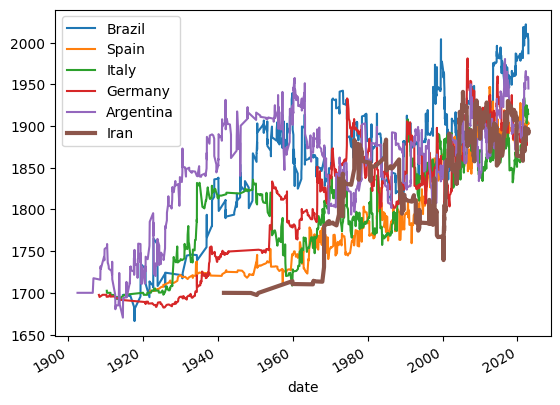

In [418]:
# Visualise a few teams
elo_df[elo_df['team']=='Brazil']['rating'].plot(label='Brazil')
elo_df[elo_df['team']=='Spain']['rating'].plot(label='Spain')
elo_df[elo_df['team']=='Italy']['rating'].plot(label='Italy')
elo_df[elo_df['team']=='Germany']['rating'].plot(label='Germany')
elo_df[elo_df['team']=='Argentina']['rating'].plot(label='Argentina')
elo_df[elo_df['team']=='Iran']['rating'].plot(label='Iran', lw=3)
plt.legend()

In [322]:
# Lets say we're only interest in the last 4 years of data (inc the last world cup)
elo_recent=elo_df.loc['01-01-2018':]


In [391]:
elo_recent.tail()

,date,team,rating
date,,,
2022-12-02,2022-12-02,Brazil,1989.655928
2022-12-02,2022-12-02,Ghana,1689.734797
2022-12-02,2022-12-02,Uruguay,1788.402805
2022-12-02,2022-12-02,Korea Republic,1892.861338
2022-12-02,2022-12-02,Portugal,1895.297602


In [323]:
# Get the world cup fixtures
world_cup_schedule=pd.read_csv('../data/fifa-world-cup-2022-UTC.csv')
world_cup_schedule.head()

,Match Number,Round Number,Date,Location,Home Team,Away Team,Group,Result
0,1,1,20/11/2022 16:00,Al Bayt Stadium,Qatar,Ecuador,Group A,NaN
1,3,1,21/11/2022 13:00,Khalifa International Stadium,England,Iran,Group B,NaN
2,2,1,21/11/2022 16:00,Al Thumama Stadium,Senegal,Netherlands,Group A,NaN
3,4,1,21/11/2022 19:00,Ahmad Bin Ali Stadium,USA,Wales,Group B,NaN
4,8,1,22/11/2022 10:00,Lusail Stadium,Argentina,Saudi Arabia,Group C,NaN


In [324]:
# Extract the teams 
wc_teams=pd.unique(world_cup_schedule[['Home Team','Away Team']].values.ravel()).tolist()

# remove TBC match data
drop_list=['1A', '2B', '1C', '2D', '1D', '2C',
       '1B', '2A', '1E', '2F', '1G', '2H', '1F', '2E', '1H', '2G',
       'To be announced']

wc_teams=list(set(wc_teams) - set(drop_list))

In [325]:
elo_wc=elo_recent[elo_recent['team'].isin(wc_teams)]

In [326]:
elo_wc_teams=elo_wc['team'].unique()
elo_wc_teams

array(['Denmark', 'Morocco', 'Cameroon', 'Korea Republic', 'USA',
       'Mexico', 'Saudi Arabia', 'Iran', 'Qatar', 'Wales', 'France',
       'Germany', 'Spain', 'Switzerland', 'Argentina', 'Japan',
       'Netherlands', 'England', 'Australia', 'Croatia', 'Poland',
       'Portugal', 'Brazil', 'Costa Rica', 'Senegal', 'Serbia', 'Tunisia',
       'Uruguay', 'Canada', 'Belgium', 'Ghana', 'Ecuador'], dtype=object)

In [327]:
elo_recent[elo_recent['team']=='Denmark']['rating'].std()

27.139765780414436

In [356]:
def model_game(team_a, team_b, SIM_NO=10000, plot=False, no_std=2):

    team_a_sim_elos=[]
    team_b_sim_elos=[]

    team_a_elo=elo_recent[elo_recent['team']==team_a]['rating'].iloc[-1]
    team_a_elo_std=elo_recent[elo_recent['team']==team_a]['rating'].std()

    team_b_elo=elo_recent[elo_recent['team']==team_b]['rating'].iloc[-1]
    team_b_elo_stdev=elo_recent[elo_recent['team']==team_b]['rating'].std()

    print('Modelling: '+team_a+' ('+str(int(team_a_elo))+') vs '+team_b+' ('+str(int(team_b_elo))+')')

    for i in range(0,SIM_NO):
        team_a_sim_elos.append(random.gauss(team_a_elo, no_std*team_a_elo_std))
        team_b_sim_elos.append(random.gauss(team_b_elo, no_std*team_b_elo_stdev))

    team_a_results=[]
    team_b_results=[]
    for i in range(0,SIM_NO):
        result=expected(team_a_sim_elos[i], team_b_sim_elos[i])
        team_a_results.append(result)
        team_b_results.append(1-result)

    # # Change of Team A winning
    # p_a_win=np.round(100*((np.array(team_a_results)>0.62).sum()/SIM_NO),2)

    # # Change of Team A Drawing
    # p_draw=np.round(100*(((np.array(team_a_results)>0.38) & (np.array(team_a_results)<0.62)).sum()/SIM_NO),2)

    # # Change of Team A Losing
    # p_b_win=np.round(100*((np.array(team_a_results)<0.38).sum()/SIM_NO),2)

    p_a_win=np.round(np.array(team_a_results).sum()/SIM_NO,2)
    p_b_win=np.round(1-p_a_win,2)

    result=None
    if p_a_win>0.55:
        result=team_a+' WIN!'
    elif p_a_win<0.45:
        result=team_b+' WIN!'
    else:
        result='DRAW!'
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.hist(team_a_results,alpha=0.5,bins=20,label=team_a)
        plt.hist(team_b_results,alpha=0.5,bins=20,label=team_b)
        plt.legend()
        plt.axvline(x=0.5,ls='--',c='k',alpha=0.5)
        plt.axvline(x=0.45,ls='--',c='r',alpha=0.5)
        plt.axvline(x=0.55,ls='--',c='r',alpha=0.5)

        plt.text(x=0.44,y=100,s='Draw  zone',c='r')

    

    return p_a_win, p_b_win, result

Modelling: Senegal (1801) vs Netherlands (1919)


(0.39, 0.61, 'Netherlands WIN!')

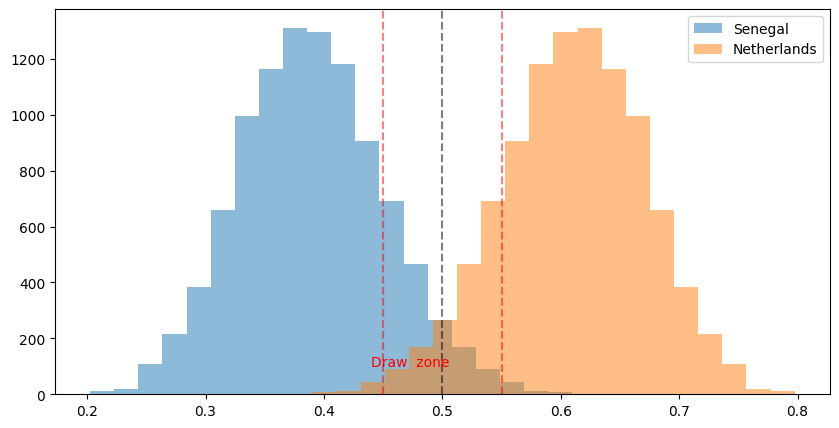

In [357]:
model_game('Senegal','Netherlands',plot=True)



In [358]:
# Let's re-calculate the elo over time for each team based on the historical match with some extra features

# initialize ratings to keep track of current values
team_names=list(fix['home_team'].unique())
current_ratings={}
for t in team_names:
    current_ratings[t]=1500

dates=[]
teams=[]
ratings=[]

# New features
opponent_rating=[]
goals_scored=[]
goals_conceded=[]
    
# For each match
for index, row in fix.iterrows():

    # try/except for some sketchy data
    try:
        adj_k=35
        if row['tournament']=='Friendly':
            adj_k=10

        new_home_rating=[]
        new_away_rating=[]

        # Extract teams and current ELO
        home_team=row['home_team']
        away_team=row['away_team']
        home_current=current_ratings[home_team]
        away_current=current_ratings[away_team]
        
        # if home win:
        if (row['home_score']>row['away_score']):
            home_result=1
            away_result=0
        # if away win
        elif (row['away_score']<row['home_score']):
            home_result=0
            away_result=1    
        # else draw
        else:
            home_result=0.5
            away_result=0.5

        # append date, team and rating home
        dates.append(row['date'])
        teams.append(home_team)
        ratings.append(elo(home_current,expected(home_current,away_current),home_result,k=adj_k))
        current_ratings[home_team]=elo(home_current,expected(home_current,away_current),home_result,k=adj_k)
        opponent_rating.append(away_current)
        goals_scored.append(row['home_score'])
        goals_conceded.append(row['away_score'])
        
        # and the same for the away team
        dates.append(row['date'])
        teams.append(away_team)
        ratings.append(elo(away_current,expected(away_current,home_current),away_result,k=adj_k))
        current_ratings[away_team]=elo(away_current,expected(away_current,home_current),away_result,k=adj_k)
        opponent_rating.append(home_current)
        goals_scored.append(row['away_score'])
        goals_conceded.append(row['home_score'])

    except Exception as e:
        print(e)


'Asturias'
'Crimea'
'Crimea'
'Crimea'
'Crimea'
'Crimea'
'Two Sicilies'
'Two Sicilies'
'Two Sicilies'
'Two Sicilies'
'Surrey'
'Maule Sur'
'Maule Sur'


In [359]:
elo_df_ext=pd.DataFrame({'date': dates,
                         'team':teams,
                         'rating':ratings,
                         'opponent_rating':opponent_rating,
                         'goals_scored':goals_scored,
                         'goals_conceded': goals_conceded
                        })
elo_df_ext.index=pd.to_datetime(elo_df_ext['date'])
elo_df_ext.head()

elo_df_ext['team'] = elo_df_ext['team'].replace(['United States'], 'USA')
elo_df_ext['team'] = elo_df_ext['team'].replace(['South Korea'], 'Korea Republic')


In [360]:
elo_df_ext_recent=elo_df_ext.loc['01-01-2018':]

In [361]:
elo_df_ext_wc=elo_df_ext_recent[elo_df_ext_recent['team'].isin(wc_teams)]

In [421]:
fix['tournament'].value_counts()[:20]

Friendly                                17461
FIFA World Cup qualification             7774
UEFA Euro qualification                  2593
African Cup of Nations qualification     1932
FIFA World Cup                            948
Copa América                              841
AFC Asian Cup qualification               764
African Cup of Nations                    742
CECAFA Cup                                620
CFU Caribbean Cup qualification           606
Merdeka Tournament                        595
British Championship                      505
UEFA Nations League                       468
Gulf Cup                                  380
AFC Asian Cup                             370
Gold Cup                                  358
Island Games                              350
UEFA Euro                                 337
COSAFA Cup                                309
AFF Championship                          293
Name: tournament, dtype: int64

In [362]:
# Train 'goal scoring' and 'goal conceding models'

from sklearn import linear_model


gs_models={}
gc_models={}

scaler = MinMaxScaler(feature_range=(0,5))
scaler.fit(elo_df_ext_wc[['rating','opponent_rating']].values)


for t in wc_teams:
    
    data=elo_df_ext_wc[elo_df_ext_wc['team']==t].dropna()
    print('Processing '+t+' ('+str(len(data))+' matches)')
    X=scaler.transform(data[['rating','opponent_rating']].values)
    y_gs=data[['goals_scored']].values.ravel()
    y_gc=data[['goals_conceded']].values.ravel()

    # model_gs = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
    model_gs = linear_model.Ridge(alpha=.5)
    model_gs.fit(X, y_gs)
    gs_models[t]=model_gs

    # model_gc = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
    model_gc = linear_model.Ridge(alpha=.5)
    model_gc.fit(X, y_gc)
    gc_models[t]=model_gc


Processing Canada (46 matches)
Processing Iran (49 matches)
Processing Uruguay (52 matches)
Processing Cameroon (45 matches)
Processing Australia (39 matches)
Processing Korea Republic (62 matches)
Processing Morocco (59 matches)
Processing Denmark (59 matches)
Processing Poland (55 matches)
Processing USA (67 matches)
Processing Saudi Arabia (65 matches)
Processing Croatia (60 matches)
Processing Ecuador (50 matches)
Processing Serbia (53 matches)
Processing Costa Rica (62 matches)
Processing Mexico (78 matches)
Processing Wales (52 matches)
Processing Germany (56 matches)
Processing Senegal (56 matches)
Processing Switzerland (57 matches)
Processing Portugal (57 matches)
Processing France (61 matches)
Processing Argentina (57 matches)
Processing Ghana (38 matches)
Processing Qatar (69 matches)
Processing Tunisia (61 matches)
Processing Spain (58 matches)
Processing Japan (62 matches)
Processing Brazil (59 matches)
Processing Belgium (60 matches)
Processing England (62 matches)
Proces

In [363]:
# Test the model
gs_models['Brazil'].predict(scaler.transform(np.array([1900,1500]).reshape(1,-1)))

array([3.22145774])

In [364]:
# Test the model
gc_models['Brazil'].predict(scaler.transform(np.array([1900,1500]).reshape(1,-1)))

array([0.23777198])

In [388]:
def model_game_goals(team_a, team_b):

    team_a_elo=elo_df_ext_wc[elo_df_ext_wc['team']==team_a]['rating'].iloc[-1]
    team_b_elo=elo_df_ext_wc[elo_df_ext_wc['team']==team_b]['rating'].iloc[-1]
    
    team_a_goals_scored=gs_models[team_a].predict(scaler.transform(np.array([team_a_elo,team_b_elo]).reshape(1,-1)))
    team_b_goals_conceded=gc_models[team_b].predict(scaler.transform(np.array([team_b_elo,team_a_elo]).reshape(1,-1)))
    team_a_ave_goals=np.round((team_a_goals_scored+team_b_goals_conceded)/2,0)

    team_b_goals_scored=gs_models[team_b].predict(scaler.transform(np.array([team_b_elo,team_a_elo]).reshape(1,-1)))
    team_a_goals_conceded=gc_models[team_a].predict(scaler.transform(np.array([team_a_elo,team_b_elo]).reshape(1,-1)))
    team_b_ave_goals=np.round((team_b_goals_scored+team_a_goals_conceded)/2,0)

    # return team_a_ave_goals, team_b_ave_goals
    return team_a_goals_scored, team_b_goals_scored, team_a_goals_conceded, team_b_goals_conceded, team_a_elo, team_b_elo
    

In [389]:
model_game_goals('Qatar', 'Ecuador')

(array([1.39264302]),
 array([1.06889885]),
 array([1.11417682]),
 array([0.39084681]),
 1753.6358308371887,
 1651.6506345535506)

In [369]:
elo_df[elo_df['team']=='Brazil']['rating'].iloc[-1]

2094.9062297849005

In [370]:
elo_recent[elo_recent['team']=='Brazil']['rating'].iloc[-1]

1989.6559279611547

In [402]:
elo_df[elo_df['team']=='Brazil'].dropna().tail()

,date,team,rating
date,,,
2022-09-23,2022-09-23,Brazil,2106.738423
2022-09-27,2022-09-27,Brazil,2108.062136
2022-11-24,2022-11-24,Brazil,2100.453817
2022-11-28,2022-11-28,Brazil,2093.989481
2022-12-02,2022-12-02,Brazil,2086.086525


In [407]:
elo_df[elo_df['team']=='Germany'].dropna().tail()

,date,team,rating
date,,,
2022-09-26,2022-09-26,Germany,1955.366380
2022-11-16,2022-11-16,Germany,1954.688991
2022-11-23,2022-11-23,Germany,1956.636268
2022-11-27,2022-11-27,Germany,1957.100944
2022-12-01,2022-12-01,Germany,1955.870433
